# Chapter 8. Using convolutions to generalize
This chapter covers
* Understanding convolution
* Building a convolutional neural network
* Creating custom `nn.Module` subclasses
* The difference between the module and functional APIs
* Design choices for neural networks

## 8.1 The case for convolutions
In this section, we’ll see how convolutions deliver locality and translation invariance.
We’ll do so by taking a close look at the formula defining convolutions and applying it
using pen and paper—but don’t worry, the gist will be in pictures, not formulas.
We said earlier that taking a 1D view of our input image and multiplying it by an
`n_output_features × n_input_features` weight matrix, as is done in `nn.Linear` ,
means for each channel in the image, computing a weighted sum of all the pixels multiplied by a set of weights, one per output feature.

We also said that, if we want to recognize patterns corresponding to objects, like an
airplane in the sky, we will likely need to look at how nearby pixels are arranged, and
we will be less interested in how pixels that are far from each other appear in combination. Essentially, it doesn’t matter if our image of a Spitfire has a tree or cloud or kite in the corner or not.

In order to translate this intuition into mathematical form, we could compute the
weighted sum of a pixel with its immediate neighbors, rather than with all other pixels
in the image. This would be equivalent to building weight matrices, one per output
feature and output pixel location, in which all weights beyond a certain distance from
a center pixel are zero. This will still be a weighted sum: that is, a linear operation.

### 8.1.1 What convolutions do
We identified one more desired property earlier: we would like these localized patterns
to have an effect on the output regardless of their location in the image: that is, to be
translation invariant. To achieve this goal in a matrix applied to the image-as-a-vector we
used in chapter 7 would require implementing a rather complicated pattern of weights
(don’t worry if it is too complicated; it’ll get better shortly): most of the weight matrix
would be zero (for entries corresponding to input pixels too far away from the output
pixel to have an influence). For other weights, we would have to find a way to keep
entries in sync that correspond to the same relative position of input and output pixels.
This means we would need to initialize them to the same values and ensure that all these
tied weights stayed the same while the network is updated during training. This way, we
would ensure that weights operate in neighborhoods to respond to local patterns, and
local patterns are identified no matter where they occur in the image.

Of course, this approach is more than impractical. Fortunately, there is a readily
available, local, translation-invariant linear operation on the image: a `convolution`. We
can come up with a more compact description of a convolution, but what we are going
to describe is exactly what we just delineated—only taken from a different angle.

Convolution, or more precisely, `discrete convolution` (there’s an analogous continuous version that we won’t go into here), is defined for a 2D image as the scalar product of a weight matrix, the `kernel`, with every neighborhood in the input. Consider a
3 × 3 kernel (in deep learning, we typically use small kernels; we’ll see why later on) as
a 2D tensor

```
weight = torch.tensor([[w00, w01, w02],
                       [w10, w11, w12],
                       [w20, w21, w22]])
```
and a 1-channel, MxN image:
```
mage = torch.tensor([[i00,i01,i02,i03,...,i0N],
                     [i10,i11,i12,i13,...,i1N],
                     [i20,i21,i22,i23,...,i2N],
                     [i30,i31,i32,i33,...,i3N],
                     ...
                     [iM0,iM1m iM2, iM3, ..., iMN]])
```
We can compute an element of the output image (without bias) as follows:
```
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
```

![](images/8.1.png)

Figure 8.1 shows this computation in action.
That is, we “translate” the kernel on the `i11` location of the input image, and we
multiply each weight by the value of the input image at the corresponding location.
Thus, the output image is created by translating the kernel on all input locations and
performing the weighted sum. For a multichannel image, like our RGB image, the
weight matrix would be a 3 × 3 × 3 matrix: one set of weights for every channel, contributing together to the output values.

Note that, just like the elements in the `weight` matrix of `nn.Linear` , the weights in
the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation. Note also that the same kernel, and thus each weight in the
kernel, is reused across the whole image. Thinking back to autograd, this means the use
of each weight has a history spanning the entire image. Thus, the derivative of the loss
with respect to a convolution weight includes contributions from the entire image.

It’s now possible to see the connection to what we were stating earlier: a convolution is
equivalent to having multiple linear operations whose weights are zero almost everywhere except around individual pixels and that receive equal updates during training.
Summarizing, by switching to convolutions, we get
* Local operations on neighborhoods
* Translation invariance
* Models with a lot fewer parameters

The key insight underlying the third point is that, with a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case
in our fully connected model, but rather on the size of the convolution kernel (3 × 3,
5 × 5, and so on) and on how many convolution filters (or output channels) we decide
to use in our model.

## 8.2 Convolutions in action
Well, it looks like we’ve spent enough time down a rabbit hole! Let’s see some PyTorch
in action on our birds versus airplanes challenge. The `torch.nn` module provides convolutions for 1, 2, and 3 dimensions: `nn.Conv1d` for time series, `nn.Conv2d` for images, and `nn.Conv3d` for volumes or videos.

For our CIFAR-10 data, we’ll resort to `nn.Conv2d` . At a minimum, the arguments we
provide to `nn.Conv2d` are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output
features, and the size of the kernel. For instance, for our first convolutional module,
we’ll have 3 input features per pixel (the RGB channels) and an arbitrary number of
channels in the output—say, 16. The more channels in the output image, the more the
capacity of the network. We need the channels to be able to detect many different types
of features. Also, because we are randomly initializing them, some of the features we’ll
get, even after training, will turn out to be useless. 2 Let’s stick to a kernel size of 3 × 3.

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever `kernel_size=3` is specified for a 2D convo-
lution, it means 3 × 3 (provided as a tuple (3, 3) in Python). For a 3D convolution, it
means 3 × 3 × 3. The CT scans we will see in part 2 of the book have a different voxel
(volumetric pixel) resolution in one of the three axes. In such a case, it makes sense to
consider kernels that have a different size for the exceptional dimension. But for now,
we stick with having the same size of convolutions across all dimensions:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [8]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3) # Instead of the shortcut kernel_size=3, we
                                       # could equivalently pass in the tuple that we
                                       # see in the output: kernel_size=(3, 3).
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? The kernel is of size 3 × 3, so
we want the weight to consist of 3 × 3 parts. For a single output pixel value, our kernel
would consider, say, `in_ch = 3` input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape `in_ch × 3 × 3`. Finally, we have as many of those as we have output channels,
here `out_ch = 16`, so the complete weight tensor is `out_ch × in_ch × 3 × 3`, in our case
16 × 3 × 3 × 3. The bias will have size 16 (we haven’t talked about bias for a while for
simplicity, but just as in the linear module case, it’s a constant value we add to each
channel of the output image). Let’s verify our assumptions:

In [10]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can see how convolutions are a convenient choice for learning from images. We
have smaller models looking for local patterns whose weights are optimized across the
entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image. In our case, both the kernel weights and the bias `conv.weight` are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with
`unsqueeze` if we want to call the `conv` module with one input image, since `nn.Conv2d`
expects a B × C × H × W shaped tensor as input:

In [11]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output, shown in figure 8.2:

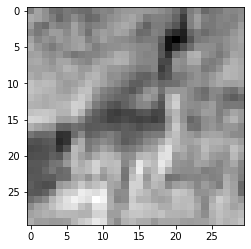

In [12]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Wait a minute. Let’s take a look a the size of `output` : it’s `torch.Size([1, 16, 30,
30])` . Huh; we lost a few pixels in the process. How did that happen?

### 8.2.1 Padding the boundary
The fact that our output image is smaller than the input is a side effect of deciding what
to do at the boundary of the image. Applying a convolution kernel as a weighted sum
of pixels in a 3 × 3 neighborhood requires that there are neighbors in all directions. If
we are at i00, we only have pixels to the right of and below us. By default, PyTorch will
slide the convolution kernel within the input picture, getting `width - kernel_width + 1`
horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side.
This explains why we’re missing two pixels in each dimension.

However, PyTorch gives us the possibility of **padding** the image by creating **ghost** pixels around the border that have value zero as far as the convolution is concerned. Figure 8.3 shows padding in action.
In our case, specifying `padding=1` when `kernel_size=3` means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image. 3 The net result is that the output has
now the exact same size as the input:

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

![](images/8.2.png)
Note that the sizes of `weight` and `bias` don’t change, regardless of whether padding is
used.

There are two main reasons to pad convolutions. First, doing so helps us separate
the matters of convolution and changing image sizes, so we have one less thing to
remember. And second, when we have more elaborate structures such as skip con-
nections (discussed in section 8.5.3) or the U-Nets we’ll cover in part 2, we want the
tensors before and after a few convolutions to be of compatible size so that we can
add them or take differences.

### 8.2.2 Detecting features with convolutions
We said earlier that `weight` and `bias` are parameters that are learned through back-
propagation, exactly as it happens for `weight` and `bias` in `nn.Linear` . However, we can
play with convolution by setting weights by hand and see what happens.
Let’s first zero out `bias` , just to remove any confounding factors, and then set
`weights` to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood:

In [15]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)